In [1]:

import sys                       
sys.path.append('../scripts/')
from ideal_robot_edit import *
from scipy.stats import expon, norm, uniform
from scipy.stats import multivariate_normal
from enum import Enum
import random 
import copy

In [2]:
class Mode(Enum):
    STATE_TRANSITION = 1
    STRAIGHT_TRANSITION = 2
    SHIFT_TRANSITION = 3

In [3]:
class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/180, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        #noise に必要な変数
        #大域でグラフを生成しないと関数の呼び出しごとに関数を生成することになる
        #出てくる値がランダムじゃなくなる
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        
        #biasに必要な関数
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        #stuckに必要な関数
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        #kidnapに必要な関数
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
        #one_stepに必要な関数
        self.is_first = True
#         self.const_nu = 0
#         self.const_omega = 0
        
        self.const_time = 1.0
        self.sensor_time = self.const_time
        
#         self.const_pose = self.pose
        self.distance_maximum = 340
        self.distance_minimum = 30
        
        self.sensor_stuck = []
        self.shift_switch = False
        
        self.keep_straight = False
        self.keep_shift = False
        
        self.mode = Mode.STATE_TRANSITION
        
        self.obs_stuck = 0
        self.obs_sign = 0
        
        self.angle = 3
        
        self.a = 0
        self.b = 0
        
        self.accelerate_rate = 5
        self.accelerate_nu = False
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
         
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
        
    def sensor_append(self, mode, obs):
        if mode == True:
            if obs:
                self.sensor_stuck.append(obs)
    
    
    def sensor_return(self,obs):
        if obs:         
            if np.abs(obs[0][0][1]) > self.angle /180 * math.pi :
                self.obs_stuck = np.abs(obs[0][0][1]) - self.angle / 180 * math.pi
                self.obs_sign = np.sign(obs[0][0][1])
                return  self.obs_sign * self.angle / 180 * math.pi
            else:
                return obs[0][0][1]

        if self.obs_stuck > self.angle / 180 * math.pi:
            self.obs_stuck = self.obs_stuck - self.angle / 180 * math.pi
            return self.obs_sign *  self.angle / 180 * math.pi
        else:
            self.a = self.obs_stuck
            self.b = self.obs_sign
            self.obs_stuck = 0
            self.obs_sign = 0
            return self.a *self.b / 180 * math.pi
            
        
                
    def straight_transition(self,nu,omega,time,obs):
        if obs:  
            if obs[0][0][0] < self.distance_minimum:
                self.keep_straight = False
                print(obs[0][0][0])
                print("false")
            else:
                self.keep_straight = True
                print(obs[0][0][0])
                print("True")
            
        t0 = self.pose[2]        
            
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu* self.accelerate_rate * math.cos(t0)*time, 
                             nu* self.accelerate_rate *math.sin(t0)*time,
                             omega*time  + self.sensor_return(obs)] )
        else:
            return self.pose + np.array( [nu * self.accelerate_rate / omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                             nu * self.accelerate_rate / omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                             omega*time + self.sensor_return(obs) ] )
        
                    
    def shift_transition(self, nu, omega, time, obs):
        if obs:
            if obs[0][0][0] < self.distance_minimum:
                self.keep_shift = False
            else:
                self.keep_shift = True
            
        t0 = self.pose[2]
        
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu * self.accelerate_rate *math.cos(t0)*time+2.0, 
                                 nu * self.accelerate_rate *math.sin(t0)*time,
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time+2.0)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) * math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) 
        else:
            return self.pose + np.array( [nu * self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0, 
                                 nu * self.accelerate_rate /omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0)**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 )) * math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0)))**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 ))
         
   
    # mode change function
    def mode_change(self,mode,obs):
        return Mode.STATE_TRANSITION        
#         if ((obs[0][0][0] > self.distance_maximum) and(self.shift_switch == False)) or (self.keep_straight == True) :           
#             return Mode.STRAIGHT_TRANSITION
#         elif ((obs[0][0][0] > self.distance_maximum) and (self.shift_switch == True)) or (self.keep_shift == True):
#             return Mode.SHIFT_TRANSITION
#         else:


        
    
    def transition(self,mode, nu,omega, time,obs):
        if mode == Mode.STATE_TRANSITION:
            return self.state_transition(nu,omega,time,self.pose)
        elif mode == Mode.STRAIGHT_TRANSITION:
            return self.straight_transition(nu,omega, time, obs)
        elif mode == Mode.SHIFT_TRANSITION:
            #print(self.shift_transition(nu,omega,time, obs))
            return self.shift_transition(nu,omega,time, obs)
        else:
            return self.state_transition(nu,omega,time, self.pose)
    
    
    def sensor_count(self, time_interval):
        if(self.sensor_time >= 0.1) and (self.is_first == False):
            self.sensor_time -= time_interval
            return None
        elif self.is_first == True:
            self.is_first = False
            return self.sensor.data(self.pose) if self.sensor else None
        else:
            self.sensor_time = self.const_time
            return self.sensor.data(self.pose) if self.sensor else None
        
    def one_step(self,time_interval):
        if not self.agent: return
        
        obs = self.sensor_count(time_interval)
            
        self.sensor_append(True,obs)
            
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu,omega)
        nu, omega = self.stuck(nu,omega,time_interval)
        
        if obs:
            self.mode = self.mode_change(self.mode,obs)
        
        self.pose = self.transition(self.mode,nu,omega,time_interval,obs)

        self.pose = self.noise(self.pose, nu,omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)


In [4]:


# In[3]:


class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 340),
                 direction_range=(-math.pi, math.pi),
                 distance_noise_rate=0.05, direction_noise=math.pi/180,
                 distance_bias_rate_stddev=0.05, direction_bias_stddev=math.pi/180,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            #print("camera data obj=",lm.pos)
            #print("camera data cam=", cam_pose)
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            #print("a", self.visible(z))
            if self.visible(z):
                #print("b")
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
                
            
        self.lastdata = observed 
        return observed



In [5]:
class Particle: 
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        #print("particle: ",self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更_
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)


In [6]:
class Mcl:    ###mlparticle（12〜18行目）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        self.ml = self.particles[0] #追加
        self.pose = self.ml.pose #追加（互換性のため）
        
        self.sigma_xs = []
        self.sigma_ys = []
        
    def set_ml(self): #追加
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
        
    def motion_update(self, nu, omega, time):
        x_particle = []
        y_particle = []
        for p in self.particles: 
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            x_particle.append(p.pose[0])
            y_particle.append(p.pose[1])
        self.sigma_xs.append(np.std(x_particle))
        self.sigma_ys.append(np.std(y_particle))
            
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行
        self.resampling() 
            
    def resampling(self): ###systematicsampling
        ws = np.cumsum([e.weight for e in self.particles]) #重みを累積して足していく（最後の要素が重みの合計になる）
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの合計が0のときの処理
            
        step = ws[-1]/len(self.particles)   #正規化されていない場合はステップが「重みの合計値/N」になる
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []            #抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])  #もしかしたらcur_posがはみ出るかもしれませんが例外処理は割愛で
                r += step
            else:
                cur_pos += 1

        self.particles = [copy.deepcopy(e) for e in ps]                   #以下の処理は前の実装と同じ
        for p in self.particles: p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):  
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys,                                angles='xy', scale_units='xy',color="orange", alpha=0.5)) #変更

In [7]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        if observation:
            self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(0, 220,s, fontsize=8))


<IPython.core.display.Javascript object>


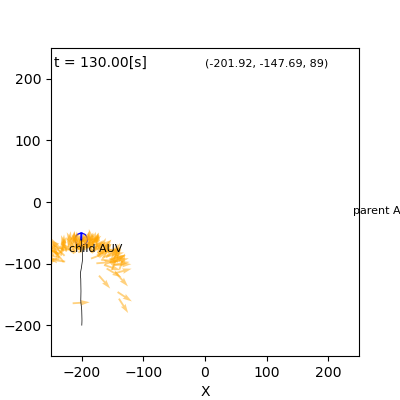

In [8]:
time_interval = 0.1
world = World(130, time_interval, debug = False)

m = Map()
straight = Agent(2.0,0)
initial_pose_1 = np.array([0,0,0]).T

m.append_landmark(Landmark(initial_pose_1, agent = straight))

world.append(m)    

initial_pose_2 = np.array([-200,-200,math.pi / 2 ]).T
estimator2 = Mcl(m,initial_pose_2,100)
b = EstimationAgent(time_interval, 1,0,estimator2) 
r_2 = Robot(initial_pose_2 , sensor = Camera(m),agent = b, color = "blue")
world.append(r_2)

world.draw()

C:\Users\furut\AppData\Local\Temp\ipykernel_13940\1972691264.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0", "20", "40", "60", "80", "100", "120"])


<IPython.core.display.Javascript object>


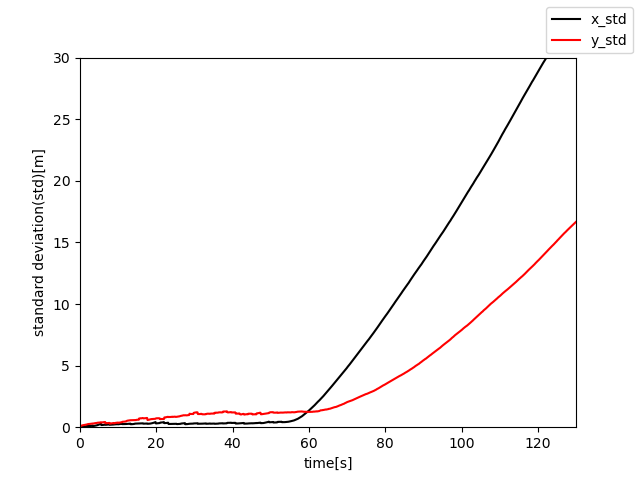

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(estimator2.sigma_xs,color = "k",label = "x_std")
plt.plot(estimator2.sigma_ys, color = "r", label = "y_std")
ax.set_xlabel("time[s]")
ax.set_ylim([0.0,30])
ax.set_xlim([0.0,1300])
ax.set_ylabel("standard deviation(std)[m]")
ax.set_xticklabels(["0", "20", "40", "60", "80", "100", "120"])
fig.legend()
plt.show()